In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 전처리

## 데이터 로드

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/colab_data/kdt/study2/dataset/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/colab_data/kdt/study2/dataset/test.csv')

In [4]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 65863


In [5]:
train_data[:5]

,ID,text,label
0,0,유소영비호감 성형아줌마,1
1,1,나오지마라 썅,3
2,2,식상하고 지긋지긋했는데 잘 끝나네 오예 소리벗고 빤스질러~~!!!,6
3,3,성희롱 당할 얼굴이 아닌데?ㅋㅋㅋ,5
4,4,"""끝까지 해보자~쪽파리 원숭이 자한 쓰레기당""",0


In [6]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 13491


In [7]:
test_data[:5]

,ID,text,label
0,0,"""솔직히 우리나라 청년들도 불쌍하고 아재들도 불쌍하고 노인들도 불쌍하다. 나라가 참""",NaN
1,1,그만 보고싶네요 .늙은애들은.,NaN
2,2,"""더러운 개신교벌레 새퀴""",NaN
3,3,근데전태수씨 사망이유가뭔가요그어떤기사에도 나오질않네요,NaN
4,4,"""태극기부대와 틀닭바퀴충들에게 순시리는 국모다. ㅉㅉ""",NaN


## 데이터 정제

In [8]:
# text 열과 label 열의 중복을 제외한 값의 개수
train_data['text'].nunique(), train_data['label'].nunique()

(65334, 7)

In [9]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['text'], inplace=True)

In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 65334


<Axes: >

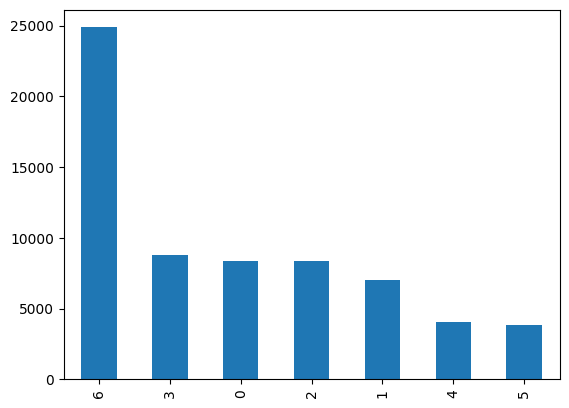

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   8397
1      1   7018
2      2   8397
3      3   8768
4      4   4038
5      5   3836
6      6  24880


In [13]:
print(train_data.isnull().values.any())

False


In [14]:
# 한글과 공백을 제외하고 모두 제거

train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-14-5d8bb34786db>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,ID,text,label
0,0,유소영비호감 성형아줌마,1
1,1,나오지마라 썅,3
2,2,식상하고 지긋지긋했는데 잘 끝나네 오예 소리벗고 빤스질러,6
3,3,성희롱 당할 얼굴이 아닌데ㅋㅋㅋ,5
4,4,끝까지 해보자쪽파리 원숭이 자한 쓰레기당,0


In [15]:
# 정규 표현식 외에 문자를 제외한 후 null 검사

train_data['text'] = train_data['text'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['text'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ID        0
text     63
label     0
dtype: int64


<ipython-input-15-967721ec192c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [16]:
train_data.loc[train_data.text.isnull()][:5]

,ID,text,label
870,870,NaN,5
1102,1102,NaN,6
1266,1266,NaN,3
1482,1482,NaN,6
1604,1604,NaN,6


In [17]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

65271


In [18]:
# 테스트 데이터는 정규 표현식 처리만 수행

test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

<ipython-input-18-a0caa3cdc18e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


## 토큰화

불용어를 제거 - 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많다. 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용할 수 있다. - 후에 불용어 추가하고 정확도 비교해보기

In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [20]:
okt = Okt()

Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기. 한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용함. stem = True를 사용하면 일정 수준의 정규화를 수행해주는데, 예를 들어 '이런'이 '이렇다'로 변환되고 '만드는'이 '만들다'로 변환됨.
 train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장

In [21]:
X_train = []
for sentence in tqdm(train_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 65271/65271 [03:52<00:00, 281.17it/s]


In [22]:
print(X_train[:3])

[['유소영', '비호감', '성형', '아줌마'], ['나오다', '썅'], ['식상하다', '지긋지긋하다', '자다', '끝나다', '오예', '소리', '벗다', '빤스질러']]


In [23]:
# 테스트 데이터도 동일하게 수행

X_test = []
for sentence in tqdm(test_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 13491/13491 [00:47<00:00, 284.81it/s]


## 정수 인코딩

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 함. 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들고, 훈련이 잘 진행될 수 있게 약간 정제한 후 정수로 변환

In [24]:
# 단어 집합 생성 및 단어에 교유한 정수 부여

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
print(tokenizer.word_index)

{'보다': 1, '을': 2, '다': 3, 'ㅋㅋ': 4, '여자': 5, '아니다': 6, '들다': 7, '없다': 8, '못': 9, '있다': 10, '아': 11, '생기다': 12, '되다': 13, '이다': 14, '같다': 15, '네': 16, '안': 17, '만': 18, '딱': 19, '로': 20, '남자': 21, '나': 22, '고': 23, '왜': 24, '진짜': 25, '틀': 26, 'ㅋㅋㅋ': 27, '니': 28, '년': 29, '사람': 30, '좋다': 31, '문': 32, '에서': 33, '저': 34, '그렇다': 35, '새끼': 36, '그': 37, '지': 38, '하고': 39, '나오다': 40, '가다': 41, '라': 42, '게': 43, '얼굴': 44, '먹다': 45, '돼지': 46, '뭐': 47, '야': 48, '개': 49, '대다': 50, '놈': 51, '말': 52, '많다': 53, '더': 54, 'ㅋ': 55, '한국': 56, '인': 57, '재앙': 58, '댓글': 59, '것': 60, '한테': 61, '냐': 62, '애': 63, '돈': 64, '하': 65, '이나': 66, '거': 67, '나라': 68, '않다': 69, '때': 70, '너무': 71, '그냥': 72, '면': 73, '치다': 74, '알다': 75, '적': 76, '지다': 77, '오다': 78, '문재인': 79, '일': 80, '받다': 81, '나이': 82, '중국': 83, '인데': 84, '전라도': 85, '또': 86, '내': 87, '들이다': 88, '랑': 89, '생각': 90, '모르다': 91, '이쁘다': 92, '너': 93, '시키다': 94, '나다': 95, '대': 96, '까지': 97, '이렇다': 98, '차다': 99, '이네': 100, '맞다': 101, '결혼': 102, '짱깨': 103, '서': 1

각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미함. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인하고, 훈련에 배제시켜 보자

In [26]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 34353
등장 빈도가 2번 이하인 희귀 단어의 수: 20359
단어 집합에서 희귀 단어의 비율: 59.26411084912526
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.49193203113485


In [27]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 13995


In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
print(X_train[:3])

[[8830, 944, 243, 146], [40, 3316], [2867, 3520, 111, 617, 9925, 150, 1150]]


각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있다. 단어의 개수는 13995개로 제한되었으므로 0번 단어 ~ 13995번 단어까지만 사용 중입니다. 0번 단어는 패딩을 위한 토큰임. train_data에서 y_train과 y_test를 별도로 저장

In [30]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미함. 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해줘야함. 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받자

In [31]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [32]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

65160
65160


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


훈련 데이터셋 크기 : 65271 -> 65160

## 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해야함. 

리뷰의 최대 길이 : 112
리뷰의 평균 길이 : 10.55108962553714


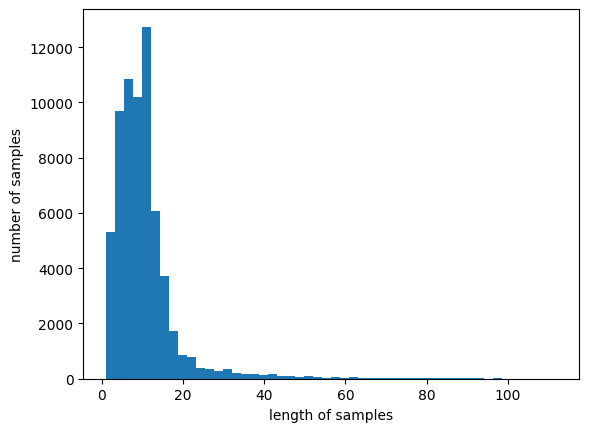

In [33]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 112이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것으로 보임. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있다. 특정 길이 변수를 max_len으로 정하고, 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값을 찾아야함. 

In [34]:
 # 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.87231430325353


In [36]:
# 모든 샘플의 길이를 30으로 맞추기

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 2. LSTM으로 분류



In [37]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(7, activation='softmax')) # 7개의 클래스에 대한 확률을 출력하는 Softmax 레이어


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

y_train_cat = to_categorical(y_train) # 각 라벨에 대한 one-hot encoding을 수행

history = model.fit(X_train, y_train_cat, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
815/815 [==============================] - ETA: 0s - loss: 1.1463 - acc: 0.6050
Epoch 1: val_acc improved from -inf to 0.72767, saving model to best_model.h5
815/815 [==============================] - 39s 38ms/step - loss: 1.1463 - acc: 0.6050 - val_loss: 0.8220 - val_acc: 0.7277
Epoch 2/15
815/815 [==============================] - ETA: 0s - loss: 0.7154 - acc: 0.7585
Epoch 2: val_acc improved from 0.72767 to 0.74747, saving model to best_model.h5
815/815 [==============================] - 9s 12ms/step - loss: 0.7154 - acc: 0.7585 - val_loss: 0.7515 - val_acc: 0.7475
Epoch 3/15
815/815 [==============================] - ETA: 0s - loss: 0.6203 - acc: 0.7888
Epoch 3: val_acc improved from 0.74747 to 0.75752, saving model to best_model.h5
815/815 [==============================] - 9s 11ms/step - loss: 0.6203 - acc: 0.7888 - val_loss: 0.7149 - val_acc: 0.7575
Epoch 4/15
815/815 [==============================] - ETA: 0s - loss: 0.5607 - acc: 0.8101
Epoch 4: val_acc did not impr

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
- 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미

ModelCheckpoint
- 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

validation_split=0.2
- 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인


In [39]:
model = load_model('best_model.h5')
preds = model.predict(X_test)

submission = pd.read_csv('/content/drive/MyDrive/colab_data/kdt/study2/dataset/submission.csv')
submission['label'] = preds.argmax(axis=1)

422/422 [==============================] - 1s 2ms/step


In [40]:
submission.to_csv('/content/drive/MyDrive/colab_data/kdt/study2/dataset/submission.csv')